# Microfinance analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import colors
from copy import deepcopy


%matplotlib inline

In [2]:
import pickle

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import (RAggregate_profile, RAggregate,
    find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings, subset_data)
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache

%load_ext autoreload
%autoreload 2

# Read data

In [3]:
df = pd.read_csv("../Data/banerjee_miracle.csv")
cols = df.columns

df.head()

,hhid,areaid,treatment,hh_edu,hh_gender,old_biz,area_pop_base,area_debt_total_base,area_business_total_base,area_exp_pc_mean_base,...,informal_amt_2,female_biz_pct_2,hours_week_2,durables_exp_mo_2,temptation_exp_mo_2,total_exp_mo_2,bizprofit_2,bizrev_2,bizemployees_2,girls_school_2
0,1,1,1,1.0,1.0,0.0,1,3,2,3,...,0.000000,NaN,84.0,138.82982,0.0000,4128.3823,0.0000,0.0000,0.0,1.0
1,2,1,1,0.0,1.0,0.0,1,3,2,3,...,0.000000,NaN,126.0,793.41240,533.1065,6835.4253,0.0000,0.0000,0.0,1.0
2,3,1,1,0.0,1.0,1.0,1,3,2,3,...,0.000000,0.0,36.0,1291.11730,0.0000,11836.0750,2049.1282,2498.9368,0.0,NaN
3,4,1,1,0.0,1.0,1.0,1,3,2,3,...,462303.305354,1.0,84.0,347.07455,0.0000,8740.4480,2082.4473,2498.9368,1.0,1.0
4,5,1,1,0.0,1.0,1.0,1,3,2,3,...,45813.841071,0.0,63.0,104.12237,0.0000,6607.4670,NaN,74634.0800,0.0,NaN


In [25]:
df["treatment"] = df["treatment"] + 1
df["hh_edu"] = df["hh_edu"] + 1
df["hh_gender"] = df["hh_gender"] + 1

In [26]:
outcome_cols = cols[12:]

print(outcome_cols)

covariate_cols_id = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
covariate_cols = [cols[x] for x in covariate_cols_id]

print(covariate_cols)

Index(['anyloan_amt_2', 'informal_amt_2', 'female_biz_pct_2', 'hours_week_2',
       'durables_exp_mo_2', 'temptation_exp_mo_2', 'total_exp_mo_2',
       'bizprofit_2', 'bizrev_2', 'bizemployees_2', 'girls_school_2'],
      dtype='object')
['treatment', 'hh_edu', 'hh_gender', 'old_biz', 'area_pop_base', 'area_debt_total_base', 'area_business_total_base', 'area_exp_pc_mean_base', 'area_literate_head_base', 'area_literate_base']


In [37]:
outcome_col_id = 15
outcome_col = cols[outcome_col_id]

chosen_covariates_idx = [2, 3, 4, 5, 7, 8]
chosen_covariates = [cols[x] for x in chosen_covariates_idx]

print(f"Covariates used are {chosen_covariates}")
print(f"Outcome is {outcome_col}")

df2 = df.copy()
df2 = df2.dropna(subset=[outcome_col], axis=0)

Z = df2.to_numpy()

X = Z[:, chosen_covariates_idx]
y = Z[:, outcome_col_id]
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

num_data = X.shape[0]
print(f"There are {num_data} data points")

Covariates used are ['treatment', 'hh_edu', 'hh_gender', 'old_biz', 'area_debt_total_base', 'area_business_total_base']
Outcome is hours_week_2
There are 6142 data points


In [38]:
y2 = y.copy()

In [39]:
y2

array([[0.12209302],
       [0.18313953],
       [0.05232558],
       ...,
       [0.13372093],
       [0.16860465],
       [0.15552326]])

In [63]:
pd.unique(df2[outcome_col])

array([ 11000.,  25000.,   5000., ..., 110720., 134510.,  26050.])

# Analysis

In [64]:
M = 6
R = np.array([3, 3, 3, 4, 4, 4])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

In [65]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])

policy_means = loss.compute_policy_means(D, y, num_policies)

In [66]:
nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]

true_best_eff = np.max(mu_policies)
print(true_best_eff)
np.where(mu_policies == true_best_eff)

0.21031746031746032


(array([1424]),)

In [ ]:
reg = 1e-4

# With q = 6.8e-3, we got
# Best model loss 0.006677662589304398 and epsilon 0.0149752999141002
# Smallest model 32.0, largest model 49.0
# And there were 4227072 models

q =  4.6e-3

# H = 20
H = np.inf
R_set, R_profiles = RAggregate(M, R, H, D, y, q, reg=reg)
# R_set, R_profiles = RAggregate(M, R, 10, D, y, q, reg=reg)

print(len(R_set))

In [95]:

R_set = find_feasible_combinations(R_profiles, 4.6e-3, np.inf, sorted=True)
print(len(R_set))

13333


In [96]:
model_losses = []
model_sizes = []

for r_set in R_set:
    loss_r = 0
    size_r = 0
    for profile, model_prof in enumerate(r_set):
        loss_r_prof = R_profiles[profile].loss[model_prof]
        size_r_prof = R_profiles[profile].pools[model_prof]
        loss_r += loss_r_prof
        size_r += size_r_prof
    
    model_losses.append(loss_r)
    model_sizes.append(size_r)

q0 = np.min(model_losses)
eps = (np.max(model_losses) - np.min(model_losses)) / q0

print(f"Best model loss {q0} and epsilon {eps}")

print(f"Smallest model {np.min(model_sizes)}, largest model {np.max(model_sizes)}")

Best model loss 0.004299737679159057 and epsilon 0.06977152970196171
Smallest model 64.0, largest model 67.0


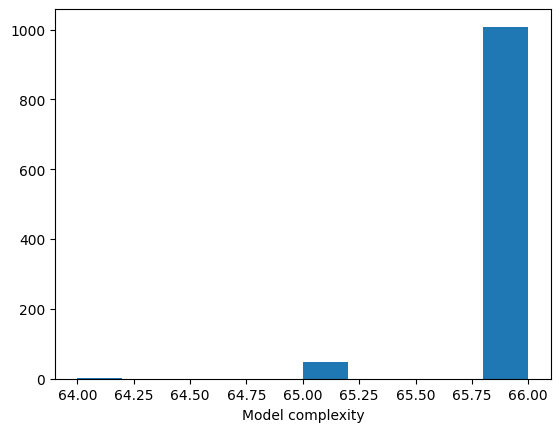

In [91]:
plt.hist(model_sizes)

plt.xlabel("Model complexity")

plt.show()

In [121]:
res_dict = {
    "outcome": outcome_col,
    "reg": reg,
    "q": q,
    "q0": q0,
    "eps": eps,
    "H": H,
    "R_set": R_set,
    "R_profiles": R_profiles
}

In [122]:
pkl_fname = "../Results/microfinance/" + outcome_col + ".pkl"

with open(pkl_fname, "wb") as f:
    pickle.dump(res_dict, f, pickle.HIGHEST_PROTOCOL)

print("Done pickling!")

Done pickling!


## Plots

In [35]:
results_dir = "../Results/microfinance/"
# outcome_str = "durables_exp_mo_2"
outcome_str = outcome_cols[0]

outcome_fname = results_dir + outcome_str + ".pkl"

In [36]:
with open(outcome_fname, "rb") as f:
    res_dict = pickle.load(f)

reg = res_dict["reg"]
q = res_dict["q"]
q0 = res_dict["q0"]
eps = res_dict["eps"]
H = res_dict["H"]
R_set = res_dict["R_set"]
R_profiles = res_dict["R_profiles"]

print(reg, q, q0, eps)

0.0001 0.0046 0.004299737679159057 0.06977152970196171


In [37]:
model_losses = []

for r_set in R_set:
    loss_r = 0
    size_r = 0
    for profile, model_prof in enumerate(r_set):
        loss_r_prof = R_profiles[profile].loss[model_prof]
        size_r_prof = R_profiles[profile].pools[model_prof]
        loss_r += loss_r_prof
        size_r += size_r_prof

    model_losses.append(loss_r)
    # model_sizes.append(size_r)

print((np.max(model_losses) - np.min(model_losses)) / np.min(model_losses))

0.06977152970196171


In [38]:
eps_to_use

0.002139246002232473

In [39]:
np.min(model_losses) == q0

True

In [40]:
counter = 0

for r_set in R_set:
    loss_r = 0
    size_r = 0
    for profile, model_prof in enumerate(r_set):
        loss_r_prof = R_profiles[profile].loss[model_prof]
        loss_r += loss_r_prof

    if loss_r <= (np.min(model_losses) * (1 + eps_to_use)):
        counter += 1
    # model_sizes.append(size_r)

print(counter)

1


In [31]:
M = 6
R = np.array([3, 3, 3, 4, 4, 4])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

features = ["Treatment", "Head Edu", "Head Gender", "Past Biz", "Debt", "Reg Biz"]


# 'anyloan_amt_2', 'informal_amt_2', 'female_biz_pct_2', 'hours_week_2',
       # 'durables_exp_mo_2', 'temptation_exp_mo_2', 'total_exp_mo_2',
       # 'bizprofit_2', 'bizrev_2', 'bizemployees_2', 'girls_school_2'
outcome_fnames = list(cols[12:])
outcome_names = ["Any Loan", "Informal Loan", "Female Biz", "Working Hours", "Durables", "Temptation",
                "Expenditure", "Profit", "Revenue", "Employees", "Girls in School"]


results_dir = "../Results/microfinance/"

num_outcomes = len(outcome_fnames)

In [19]:
eps_min = np.inf

for i, outcome_str in enumerate(outcome_fnames):
    outcome_fname = results_dir + outcome_str + ".pkl"
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    reg = res_dict["reg"]
    q = res_dict["q"]
    q0 = res_dict["q0"]
    eps = res_dict["eps"]
    H = res_dict["H"]
    R_set = res_dict["R_set"]
    R_profiles = res_dict["R_profiles"]

    print(outcome_names[i], len(R_set), q0, eps)

    eps_min = min(eps_min, eps)

print(f"eps to use: {eps_min}")

Any Loan 13333 0.004299737679159057 0.06977152970196171
Informal Loan 13333 0.0031192582167883353 0.09617670610151752
Female Biz 1057 0.27904907428374465 0.0716719811787065
Working Hours 13333 0.01480305114457307 0.2026608868200341
Durables 1057 0.004224244041596716 0.04734574944784723
Temptation 13333 0.004013143432160378 0.07475339313220042
Expenditure 13333 0.003945524543560858 0.0760354789458616
Profit 13333 0.0017313779542733596 0.0866361835453165
Revenue 13333 0.008987787807085732 0.03337859824807343
Employees 13333 0.002084221725863262 0.1439384363869692
Girls in School 3088 0.16664350592403854 0.002139246002232473
eps to use: 0.002139246002232473


In [48]:
eps_to_use = eps_min
eps_to_use = 0.03

feature_splits = np.zeros(shape=(num_outcomes, len(features)), dtype=np.float64)
profile_splits = np.zeros(shape=(num_outcomes, num_profiles))

for i, outcome_str in enumerate(outcome_fnames):

    # if i > 0:
    #     break
    
    outcome_fname = results_dir + outcome_str + ".pkl"
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    reg = res_dict["reg"]
    q = res_dict["q"]
    q0 = res_dict["q0"]
    # eps = res_dict["eps"]
    # H = res_dict["H"]
    R_set = res_dict["R_set"]
    R_profiles = res_dict["R_profiles"]

    R_set_size = 0
    
    for r, model_r in enumerate(R_set):
    
        feature_splits_r = np.zeros(shape=(len(features),))
        feature_present_r = np.zeros(shape=(len(features),), dtype=np.float64)
        profile_splits_r = np.zeros(shape=(num_profiles,))
        loss_r = 0
        
        for k, sigma_k_idx in enumerate(model_r):
            
            sigma_k = R_profiles[k].sigma[sigma_k_idx]
            loss_r += R_profiles[k].loss[sigma_k_idx]
            
            if sigma_k is None:
                continue
            
            sigma_temp = sigma_k.copy()
            sigma_temp[np.isinf(sigma_temp)] = 0
            profile_splits_r[k] += np.sum(sigma_temp)
    
            row_id = 0
            for j, present in enumerate(profiles[k]):
                if present == 1:
                    feature_splits_r[j] += np.sum(sigma_temp[row_id, :])
                    feature_present_r[j] += 1
                    row_id += 1
        
        meets_criteria = (loss_r <= (q0 * (1 + eps_to_use)))
        # meets_criteria = True
        
        if meets_criteria:
            R_set_size += 1
    
            feature_splits[i, :] += np.divide(feature_splits_r, feature_present_r)
            profile_splits[i, :] += profile_splits_r
            # profile_splits += profile_splits_r

    print(outcome_names[i], R_set_size)
    profile_splits[i, :] = profile_splits[i, :] / R_set_size
    feature_splits[i, :] = feature_splits[i, :] / R_set_size

Any Loan 49
Informal Loan 1
Female Biz 1
Working Hours 1
Durables 49
Temptation 49
Expenditure 49
Profit 49
Revenue 1546
Employees 1
Girls in School 3088


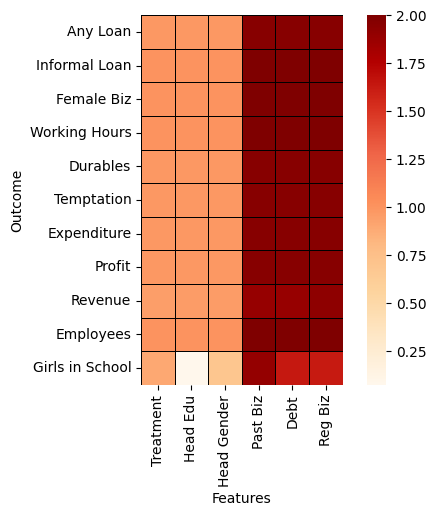

In [53]:

sns.heatmap(
    feature_splits[:, :],
    # feature_splits[:, :] / np.array([[1, 1, 1, 2, 2, 2]]),
    cmap="OrRd",
    # norm=colors.LogNorm(),
    linewidths=0.5,
    linecolor="black",
    annot=False,
    square=True
)


plt.xlabel("Features")
plt.ylabel("Outcome")

plt.yticks(np.arange(0, len(outcome_fnames)) + 0.5, outcome_names, rotation=0)

plt.xticks(np.arange(0, len(features))+0.5, features, rotation=90)

# plt.title("Feature heterogeneity")

plt.show()

In [50]:
num_possible_splits = []
for profile in profiles:
    m = np.sum(profile)
    num_possible_splits.append(2*m)

profile_splits[0, 56:] / num_possible_splits[56:]

array([0.48979592, 0.6122449 , 0.6122449 , 0.68571429, 0.6122449 ,
       0.68571429, 0.68571429, 0.73469388])

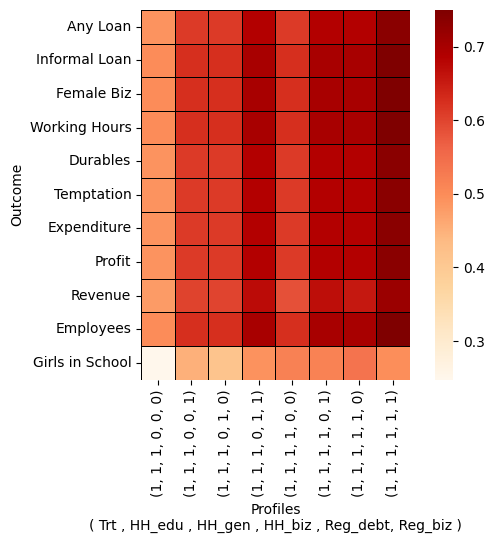

In [51]:


sns.heatmap(
    # profile_splits[:, active_profiles_idx],
    # profile_splits[0, active_profiles_idx] / np.array([[1, 4, 6, 8]]),
    # profile_splits[:, 56:],
    profile_splits[:, 56:] / np.array([num_possible_splits[56:]]),
    cmap="OrRd",
    # norm=colors.LogNorm(),
    linewidths=0.5,
    linecolor="black",
    annot=False,
    square=True
)


plt.xlabel("Profiles\n( Trt , HH_edu , HH_gen , HH_biz , Reg_debt, Reg_biz )")
plt.ylabel("Outcome")

# plt.xticks(np.arange(0, len(active_profiles_idx)) + 0.5, profile_labels, rotation=90)
plt.xticks(np.arange(0, 8)+0.5, profiles[56:], rotation=90)
# plt.yticks([0.5], ["Any loan"])

plt.yticks(np.arange(0, len(outcome_fnames)) + 0.5, outcome_names, rotation=0)

# plt.title("Heterogeneity")


plt.show()

## Treatment effects

### Format data

In [3]:
def format_data(df, outcome_col_id, chosen_covariates_idx):
    
    outcome_col = cols[outcome_col_id]
    df2 = df.copy()
    df2 = df2.dropna(subset=[outcome_col], axis=0)
    
    Z = df2.to_numpy()
    
    X = Z[:, chosen_covariates_idx]
    y = Z[:, outcome_col_id]
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    y = y.reshape((-1, 1))

    print(y)

    return X, y

def match_treatment_control_pools(pi_pools, policies_i):
    pairs = []
    found = []

    remaining_pools = list(pi_pools.keys())

    for i, pool_i in enumerate(pi_pools.keys()):
        if pool_i in found:
            continue

        policy_pool_i_0 = policies_i[pi_pools[pool_i][0]]

        j_idx = None
        for j, pool_j in enumerate(remaining_pools):
            policy_pool_j_0 = policies_i[pi_pools[pool_j][0]]
            if policy_pool_j_0[0] != policy_pool_i_0[0] and policy_pool_j_0[1:] == policy_pool_i_0[1:]:
                j_idx = j
                if policy_pool_j_0[0] == 1:
                    pairs.append([pool_j, pool_i])
                else:
                    pairs.append([pool_i, pool_j])
                break
        found += [pool_i, pool_j]
        remaining_pools = remaining_pools[:j_idx] + remaining_pools[(j_idx+1):]

    return pairs

In [52]:
def get_policy_means(M, R, X, y):
    
    num_profiles = 2**M
    profiles, profile_map = tva.enumerate_profiles(M)
    
    all_policies = tva.enumerate_policies(M, R)
    num_policies = len(all_policies)
    
    policies_profiles = {}
    policies_profiles_masked = {}
    policies_ids_profiles = {}
    for k, profile in enumerate(profiles):
    
        policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
        unzipped_temp = list(zip(*policies_temp))
        policies_ids_k = list(unzipped_temp[0])
        policies_k = list(unzipped_temp[1])
        policies_profiles[k] = deepcopy(policies_k)
        policies_ids_profiles[k] = policies_ids_k
    
        profile_mask = list(map(bool, profile))
    
        # Mask the empty arms
        for idx, pol in enumerate(policies_k):
            policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
        policies_profiles_masked[k] = policies_k

    
    D = np.zeros(shape=y.shape, dtype=np.int64)
    profiles_in_data = []
    for i in range(num_data):
        policy_i = tuple([int(x) for x in X[i, :]])
        policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
        profiles_in_data.append(tva.policy_to_profile(policy_i))
        D[i, 0] = int(policy_idx[0])

    policy_means = loss.compute_policy_means(D, y, num_policies)
    
    D_profiles = {}
    y_profiles = {}
    policy_means_profiles = {}
    for k, profile in enumerate(profiles):
        D_k, y_k = subset_data(D, y, policies_ids_profiles[k])
        D_profiles[k] = D_k
        y_profiles[k] = y_k
    
        if D_k is None:
            policy_means_profiles[k] = None
        else:
            # policy_means_k_0 = loss.compute_policy_means(D_k, y_k, len(policies_profiles[k]))
            # print(policy_means_k_0.shape)
            policy_means_k = policy_means[policies_ids_profiles[k], :]
            # print(policy_means_k.shape)
            # print(np.all(np.equal(policy_means_k_0, policy_means_k)))
            # print("--")

            policy_means_profiles[k] = policy_means_k

    return D_profiles, y_profiles, policy_means_profiles, policies_profiles_masked, policies_profiles

In [5]:
def read_pickle(results_dir, fname):

    outcome_fname = results_dir + outcome_col + ".pkl"
    
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    # reg = res_dict["reg"]
    # q = res_dict["q"]
    # q0 = res_dict["q0"]
    # eps = res_dict["eps"]
    # H = res_dict["H"]
    R_set = res_dict["R_set"]
    R_profiles = res_dict["R_profiles"]

    return R_set, R_profiles

In [77]:
def find_gender_trt_con_pairs(policies, subset_indices, trt_idx, trt_label, con_label):
    trt_con_pairs = []
    found = []
    for i in range(len(subset_indices)):
        pol_i_idx = subset_indices[i]
        pol_i = policies[pol_i_idx]
        if pol_i_idx in found:
            continue
        for j in range(i+1, len(subset_indices)):
            pol_j_idx = subset_indices[j]
            pol_j = policies[pol_j_idx]
            if pol_i[trt_idx] == pol_j[trt_idx]:
                continue
            if pol_i[:trt_idx] == pol_j[:trt_idx] and pol_i[(trt_idx+1):] == pol_j[(trt_idx+1):]:
                found.append(pol_i_idx)
                found.append(pol_j_idx)
                if pol_i[trt_idx] == con_label:
                    trt_con_pairs.append([pol_i_idx, pol_j_idx])
                else:
                    trt_con_pairs.append([pol_j_idx, pol_i_idx])
                break
    return trt_con_pairs

In [99]:
def get_counts(R_profiles, D_profiles, y_profiles,
               policies_profiles_masked,
               policies_profiles,
               policy_means_profiles,
               ignore_gender=True
            ):
    # Find all profiles with data
    active_profiles = []
    for i, partitions in enumerate(R_profiles):
        if partitions.sigma[0] is not None:
            active_profiles.append(i)

    num_active_profiles = len(active_profiles)
    
    trt_idx = 0
    trt_label = 2
    con_label = 1
    gen_idx = 2
    mal_label = 2
    fem_label = 1
    
    zero_eff_ctr = np.zeros(num_active_profiles)
    total_ctr = np.zeros(num_active_profiles)
    pos_eff_ctr = np.zeros(num_active_profiles)
    neg_eff_ctr = np.zeros(num_active_profiles)
    
    for i, profile_id in enumerate(active_profiles):
        total_ctr[i] = R_profiles[profile_id].size
    
        D_i = D_profiles[profile_id]
        y_i = y_profiles[profile_id]
        policies_i = policies_profiles_masked[profile_id]
        policy_means_i = policy_means_profiles[profile_id]
    
        
        for j in range(int(total_ctr[i])):

            sigma_i = R_profiles[profile_id].sigma[j].copy()

            policies_profile_i = policies_profiles[profile_id]
            policies_outcomes_est = np.zeros(shape=(len(policies_profile_i),))
            
            # Find the partition pools
            pi_pools, pi_policies = extract_pools.extract_pools(policies_i, sigma_i)
            mu_pools = loss.compute_pool_means(policy_means_i, pi_pools)

            for p, pool_id in pi_policies.items():
                policies_outcomes_est[p] = mu_pools[pool_id]

            trt_indices = [idx for idx, p in enumerate(policies_profile_i) if p[trt_idx] == trt_label]
            con_indices = [idx for idx, p in enumerate(policies_profile_i) if p[trt_idx] == con_label]
            mal_indices = [idx for idx, p in enumerate(policies_profile_i) if p[gen_idx] == mal_label]
            fem_indices = [idx for idx, p in enumerate(policies_profile_i) if p[gen_idx] == fem_label]

            # Find treatment control pairs for each gender
            # The first element is control and the second element is treatment
            mal_trt_pairs = find_gender_trt_con_pairs(policies_profile_i, mal_indices,
                                                     trt_idx, trt_label, con_label)
            fem_trt_pairs = find_gender_trt_con_pairs(policies_profile_i, fem_indices,
                                                     trt_idx, trt_label, con_label)

            mal_outcome_pairs = np.zeros(shape=(len(mal_trt_pairs), 2))
            fem_outcome_pairs = np.zeros(shape=(len(fem_trt_pairs), 2))

            for idx, pair in enumerate(mal_trt_pairs):
                con_pol_idx = pair[0]
                trt_pol_idx = pair[1]
                mal_outcome_pairs[idx, 0] = policies_outcomes_est[con_pol_idx]
                mal_outcome_pairs[idx, 1] = policies_outcomes_est[trt_pol_idx]
                
            for idx, pair in enumerate(fem_trt_pairs):
                con_pol_idx = pair[0]
                trt_pol_idx = pair[1]
                fem_outcome_pairs[idx, 0] = policies_outcomes_est[con_pol_idx]
                fem_outcome_pairs[idx, 1] = policies_outcomes_est[trt_pol_idx]


            mal_effects = mal_outcome_pairs[:,1] - mal_outcome_pairs[:,0]
            fem_effects = fem_outcome_pairs[:,1] - fem_outcome_pairs[:,0]

            trt_effects = np.concatenate((mal_effects, fem_effects), axis=0)
            cross_effects = fem_effects - mal_effects

            # Decide whether to use gender-treatment interaction or just the treatment
            if ignore_gender:
                eff_to_use = trt_effects
            else:
                eff_to_use = cross_effects

            eff_sign = np.sign(eff_to_use)

            eff_n = eff_sign.shape[0]

            neg_eff_i = len(np.where(eff_sign == -1)[0]) / eff_n
            zero_eff_i = len(np.where(eff_sign == 0)[0]) / eff_n
            pos_eff_i = len(np.where(eff_sign == 1)[0]) / eff_n
            
            neg_eff_ctr[i] += neg_eff_i
            zero_eff_ctr[i] += zero_eff_i
            pos_eff_ctr[i] += pos_eff_i                                    
                        

    return zero_eff_ctr, pos_eff_ctr, neg_eff_ctr, total_ctr

In [5]:
M = 6
R = np.array([3, 3, 3, 4, 4, 4])

df = pd.read_csv("../Data/banerjee_miracle.csv")
df["treatment"] = df["treatment"] + 1
df["hh_edu"] = df["hh_edu"] + 1
df["hh_gender"] = df["hh_gender"] + 1

cols = df.columns

results_dir = "../Results/microfinance/"

chosen_covariates_idx = [2, 3, 4, 5, 7, 8]
chosen_covariates = [cols[x] for x in chosen_covariates_idx]
print(f"Covariates used are {chosen_covariates}")

outcome_names = ["Any Loan", "Informal Loan", "Female Biz", "Working Hours", "Durables", "Temptation",
                "Expenditure", "Profit", "Revenue", "Employees", "Girls in School"]

profile_labels_on = [
    "None",
    "Reg. Biz",
    "Reg. Debt",
    "Reg. Debt, Reg. Biz",
    "Biz",
    "Biz, Reg. Biz",
    "Biz, Reg. Debt",
    "Biz, Reg. Debt, Reg. Biz",
]

# profile_labels_on = [x[5:] for x in profile_labels_on]
profile_labels_on = [x.replace(",", " |") for x in profile_labels_on]

Covariates used are ['treatment', 'hh_edu', 'hh_gender', 'old_biz', 'area_debt_total_base', 'area_business_total_base']


Outcome is anyloan_amt_2
There are 6142 data points
Outcome is informal_amt_2
There are 6142 data points
Outcome is female_biz_pct_2
There are 2644 data points
Outcome is hours_week_2
There are 6142 data points
Outcome is durables_exp_mo_2
There are 6140 data points
Outcome is temptation_exp_mo_2
There are 6142 data points
Outcome is total_exp_mo_2
There are 6142 data points
Outcome is bizprofit_2
There are 6090 data points
Outcome is bizrev_2
There are 6116 data points
Outcome is bizemployees_2
There are 6142 data points
Outcome is girls_school_2
There are 3942 data points


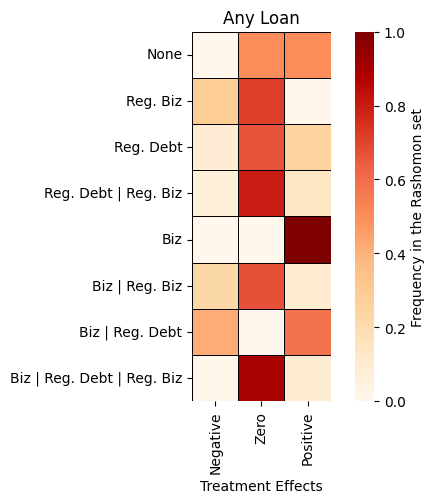

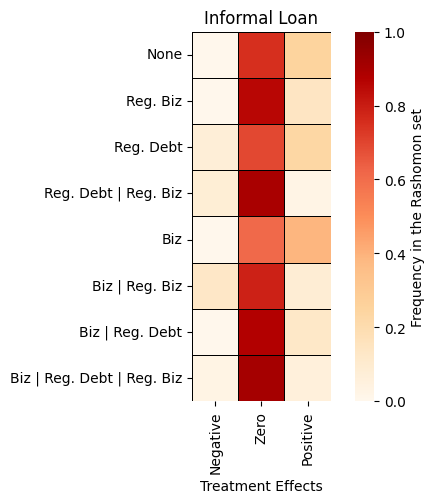

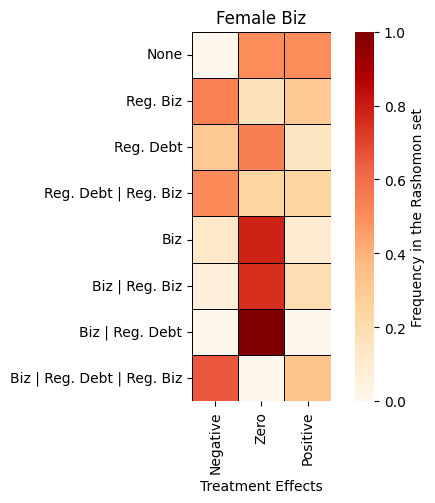

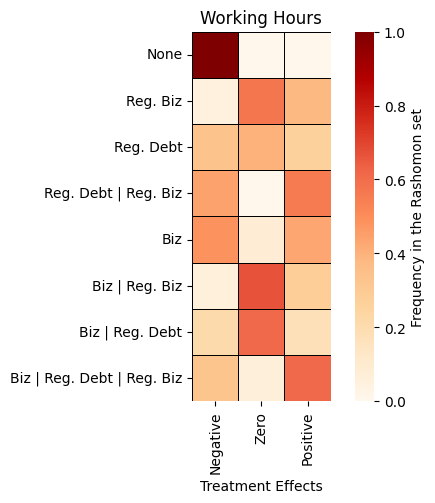

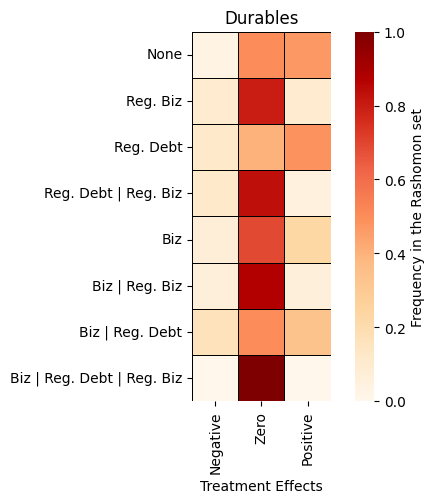

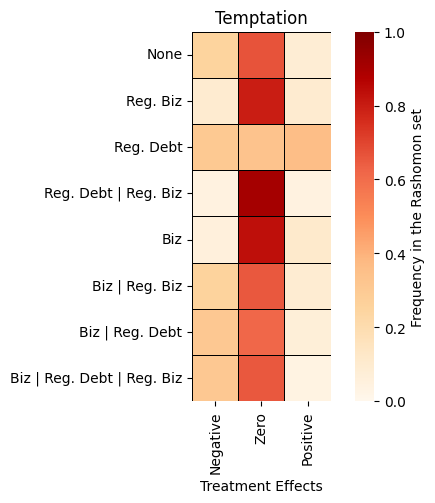

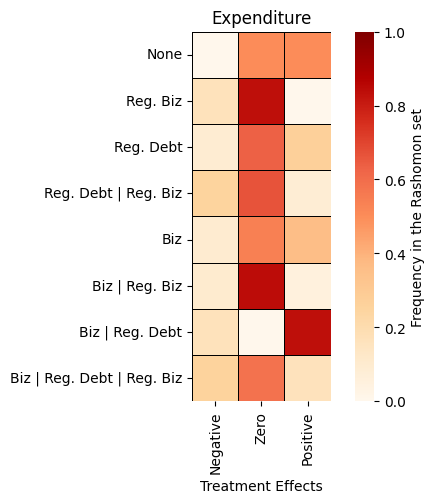

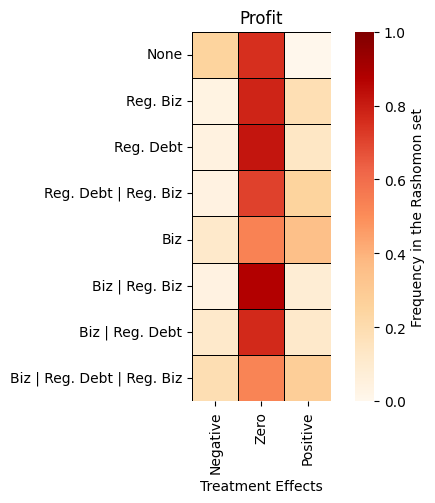

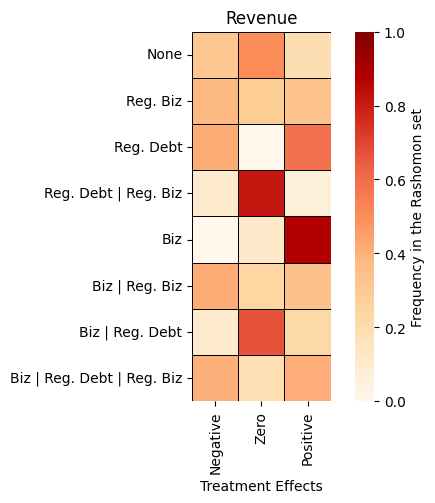

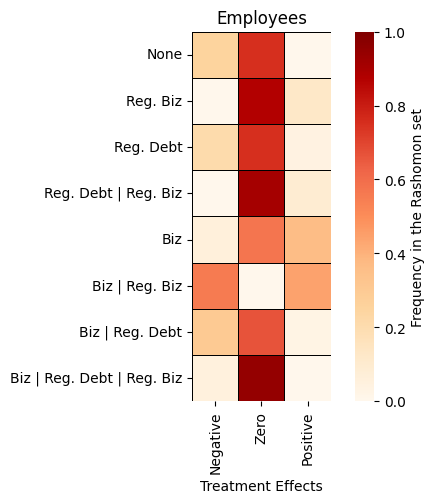

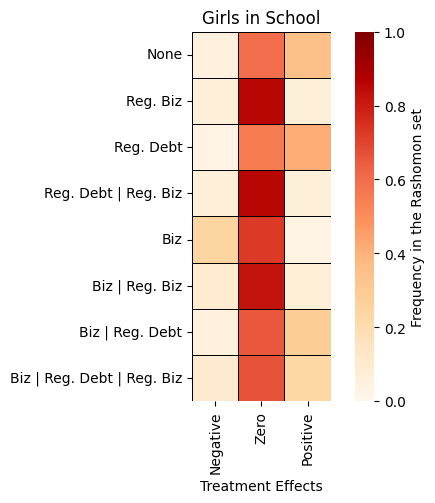

In [109]:
# outcome_col_id = 19
ignore_gender = True
        

for outcome_col_id in range(12, 23):

    # if outcome_col_id != 12:
    #     continue

    outcome_col = cols[outcome_col_id]
    outcome_title = outcome_names[outcome_col_id-12]
    
    X, y = format_data(df, outcome_col_id, chosen_covariates_idx)
    
    num_data = X.shape[0]
    
    print(f"Outcome is {outcome_col}")
    print(f"There are {num_data} data points")
    

    pol_res = get_policy_means(M, R, X, y)
    D_profiles = pol_res[0]
    y_profiles = pol_res[1]
    policy_means_profiles = pol_res[2]
    policies_profiles_masked = pol_res[3]
    policies_profiles = pol_res[4]
    
    
    R_set, R_profiles = read_pickle(results_dir, outcome_col + "_pruned")
    # R_set, R_profiles = read_pickle(results_dir, outcome_col)
    
    ctr_res = get_counts(R_profiles, D_profiles, y_profiles, policies_profiles_masked,
                         policies_profiles,
                         policy_means_profiles,
                         ignore_gender=ignore_gender
                        )
    zero_eff_ctr = ctr_res[0]
    pos_eff_ctr = ctr_res[1]
    neg_eff_ctr = ctr_res[2]
    total_ctr = ctr_res[3]
    
    plot_matrix = np.concatenate((
        neg_eff_ctr,
        zero_eff_ctr,
        pos_eff_ctr),
        axis=0).reshape((3,-1))
    
    plot_matrix = plot_matrix / total_ctr

    plt.figure()
    
    sns.heatmap(
        plot_matrix.T,
        # feature_splits[:, :] / np.array([[1, 1, 1, 2, 2, 2]]),
        cmap="OrRd",
        # norm=colors.LogNorm(),
        linewidths=0.5,
        linecolor="black",
        # annot=True,
        square=True,
        vmin=0,
        vmax=1,
        cbar_kws={
            "label": 'Frequency in the Rashomon set'
        }
    )

    
    plt.title(outcome_title)
    if not ignore_gender:
        plt.xlabel("Gender-Treatment Effects")
    else:
        plt.xlabel("Treatment Effects")
    plt.ylabel("")
    
    plt.xticks(np.arange(0, 3) + 0.5, ["Negative", "Zero", "Positive"], rotation=90)
    plt.yticks(np.arange(0, len(profile_labels_on))+0.5, profile_labels_on, rotation=0)

    fname = f"../Figures/microfinance/{outcome_col}.png"
    if not ignore_gender:
        fname = f"../Figures/microfinance/{outcome_col}_gender.png"
        
    plt.savefig(fname, dpi=300, bbox_inches="tight")

    
    # plt.show()
    # plt.cla()
    # plt.clf()

    # break

# Error estimation plot
Useful for deciding an epsilon to prune at

Outcome is anyloan_amt_2
Total of 11331 models
Best model loss 0.003474618499162904 and epsilon 0.0012609504971006268


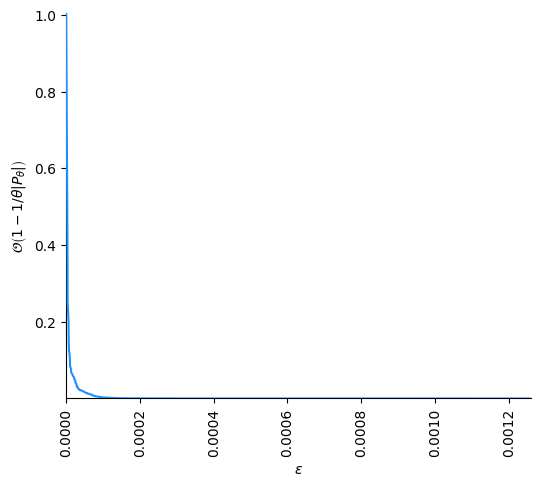

In [150]:
suffix_possibilities = [
    "",
    "_trt_edu_gen", "_trt_edu", "_trt_gen", "_trt",
    "_edu_gen", "_edu",
    "_gen"
]
selected_suffix_idx = [0, 1, 2, 3, 4, 5, 6, 7]
selected_suffixes = [suffix_possibilities[idx] for idx in selected_suffix_idx]

for outcome_col_id in range(12, 23):

    if outcome_col_id != 12:
        continue

    outcome_col = cols[outcome_col_id]    
    results_subdir = results_dir + outcome_col + "/"
    pkl_prefix = results_subdir + outcome_col
    print(f"Outcome is {outcome_col}")

    # Read files
    q0_all = []
    eps_all = []
    R_set_all = []
    R_profiles_all = []
    for suffix in selected_suffixes:
        outcome_fname = results_subdir + outcome_col + suffix + ".pkl"
        
        with open(outcome_fname, "rb") as f:
            res_dict = pickle.load(f)
        
        # reg = res_dict["reg"]
        # q = res_dict["q"]
        q0_all.append(res_dict["q0"])
        eps_all.append(res_dict["eps"])
        # H = res_dict["H"]
        R_set_all.append(res_dict["R_set"])
        R_profiles_all.append(res_dict["R_profiles"])

    
    model_losses = []
    suffix_loss_max = []
    for R_set, R_profiles in zip(R_set_all, R_profiles_all):
        this_max = -np.inf
        for r, model_r in enumerate(R_set):
            loss_r = 0
            for k, prof_k_id in enumerate(model_r):
                loss_r += R_profiles[k].loss[prof_k_id]
            model_losses.append(loss_r)
            this_max = max(this_max, loss_r)
        suffix_loss_max.append(this_max)

    print(f"Total of {len(model_losses)} models")
    
    best_loss = np.min(model_losses)
    worst_loss = np.max(model_losses)
    eps = (worst_loss - best_loss) / best_loss
    
    print(f"Best model loss {best_loss} and epsilon {eps}")
    
    # print(f"Smallest model {np.min(model_sizes)}, largest model {np.max(model_sizes)}")
    
    sorted_losses = np.sort(model_losses)
    sorted_epsilon = sorted_losses / best_loss - 1
    
    num_models = np.arange(0, len(model_losses))+1
    model_errors = np.exp(-sorted_losses) * num_models

    #
    # Plot
    #
    fig, ax = plt.subplots(figsize=(6,5))
    
    ax.spines[['right', 'top']].set_visible(False)
    plt.xticks(rotation=90)

    errors_factor = 1 / model_errors
    
    ax.plot(sorted_epsilon, errors_factor,
            color="dodgerblue",
           zorder=3.1)
    
    ax.set_xlabel(r"$\epsilon$")
    ax.set_ylabel(r"$\mathcal{O} \left( 1 - 1 / \theta |P_{\theta}| \right)$", rotation=90)

    
    # ax.set_yticks([1, 100, 200, 300, 400, 500])
    
    ax.set_xlim(0, np.max(sorted_epsilon))
    ax.set_ylim(np.min(errors_factor), np.max(errors_factor))
    
    # plt.savefig(f"../Figures/microfinance/est_error/{outcome_col}_est_error.png", dpi=300, bbox_inches="tight")
    plt.show()
    

# plt.show()

In [120]:
for outcome_col_id in range(12, 23):
    outcome_col = cols[outcome_col_id]
    # outcome_fname = results_dir + outcome_col + ".pkl"
    outcome_fname = results_dir + outcome_col + "/" + outcome_col + "_pruned.pkl"
    
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    reg = res_dict["reg"]
    q = res_dict["q"]
    # q0 = res_dict["q0"]
    eps = res_dict["eps"]
    # H = res_dict["H"]
    R_set = res_dict["R_set"]
    # R_profiles = res_dict["R_profiles"]

    print(outcome_col_id, outcome_col, reg, q, eps, len(R_set))

    break

12 anyloan_amt_2 0.0001 0.003478842003921321 0.00039987571269300563 545


## Do the pruning to smaller epsilon

In [155]:
outcome_col_id = 12
outcome_col = cols[outcome_col_id]

results_subdir = results_dir + outcome_col + "/"
pkl_prefix = results_subdir + outcome_col

suffix_possibilities = [
    "",
    "_trt_edu_gen", "_trt_edu", "_trt_gen", "_trt",
    "_edu_gen", "_edu",
    "_gen"
]


reg_all = []
q0_all = []
eps_all = []
R_set_all = []
R_profiles_all = []

selected_suffix_idx = [0, 1, 2, 3, 4, 5, 6, 7]
selected_suffixes = [suffix_possibilities[idx] for idx in selected_suffix_idx]

for suffix in selected_suffixes:
    outcome_fname = results_subdir + outcome_col + suffix + ".pkl"
    
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    reg_all.append(res_dict["reg"])
    # q = res_dict["q"]
    q0_all.append(res_dict["q0"])
    eps_all.append(res_dict["eps"])
    # H = res_dict["H"]
    R_set_all.append(res_dict["R_set"])
    R_profiles_all.append(res_dict["R_profiles"])


model_losses = []
for R_set, R_profiles in zip(R_set_all, R_profiles_all):
    for r, model_r in enumerate(R_set):
        loss_r = 0
        for k, prof_k_id in enumerate(model_r):
            loss_r += R_profiles[k].loss[prof_k_id]
        model_losses.append(loss_r)
print(len(model_losses))


best_loss = np.min(model_losses)
worst_loss = np.max(model_losses)

eps_original = worst_loss / best_loss - 1

11331


In [130]:
R_set = find_feasible_combinations(R_profiles, 0.0034754, np.inf, sorted=True)
print(len(R_set))

Min = 0.0034746184991629042, Max = 0.003510572558505532
6414


In [157]:
desired_epsilon = 1.5e-4
loss_threshold = best_loss * (1 + desired_epsilon)

R_set_pruned = []
q_pruned = []
q0_pruned = []
model_losses_pruned = []
for idx, R_set in enumerate(R_set_all):
    R_set_pruned_i = []
    q_pruned_i = -np.inf
    q0_pruned_i = np.inf
    R_profiles = R_profiles_all[idx]
    for r, model_r in enumerate(R_set):
        loss_r = 0
        for k, prof_k_id in enumerate(model_r):
            loss_r += R_profiles[k].loss[prof_k_id]
        if loss_r <= loss_threshold:
            R_set_pruned_i.append(model_r)
            q_pruned_i = max(q_pruned_i, loss_r)
            q0_pruned_i = max(q0_pruned_i, loss_r)
            model_losses_pruned.append(loss_r)
    R_set_pruned.append(R_set_pruned_i)
    q_pruned.append(q_pruned_i)
    q0_pruned.append(q0_pruned_i)

eps_new = np.max(model_losses_pruned) / np.min(model_losses_pruned) - 1


print(f"Original size = {len(model_losses)}. After pruning = {len(model_losses_pruned)}")
print(f"Origial eps = {eps_original}. After pruning = {eps_new}")


for idx, suffix in enumerate(selected_suffixes):
    pruned_outcome_fname = results_subdir + outcome_col + suffix + "_pruned.pkl"

    res_dict = {
        "reg": reg_all[idx],
        "q": q_pruned[idx],
        "q0": q0_pruned[idx],
        "eps": eps_new,
        "H": np.inf,
        "R_set": R_set_pruned[idx],
        "R_profiles": R_profiles_all[idx]
    }
    
    with open(pruned_outcome_fname, "wb") as f:
        pickle.dump(res_dict, f, pickle.HIGHEST_PROTOCOL)

Original size = 11331. After pruning = 1252
Origial eps = 0.0012609504971006213. After pruning = 0.0001499976044834206
